We have look at the data and we have seen that is a perfect 50/50 balanced dataset, so now we can start.

c:\Users\Pei Huang\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


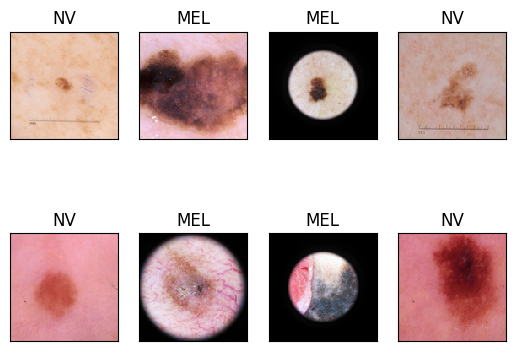

In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

folder = ImageFolder('train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

In [1]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
# resize to fit input of cnn
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # transforms.RandomVerticalFlip(),    # Random vertical flip
    # transforms.RandomRotation(45),      # Random rotation (between -45 degrees and 45 degrees)
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # # Random color jitter
    transforms.ToTensor(),
])

#load data and apply resize
train_dataset = ImageFolder('train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [2]:
# Run on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.skip1 = nn.Conv2d(3, 32, kernel_size=1) # Skip connection, resize input to 32 channels (Residual connection)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.skip2 = nn.Conv2d(32, 64, kernel_size=1) # Skip connection, resize input to 64 channels
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.skip3 = nn.Conv2d(64, 128, kernel_size=1) # Skip connection, resize input to 128 channels
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization after conv3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512) # Original Size 128*128
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))) + self.skip1(x)) # Add the result of skip connection to form the 1st residual block.
        x = self.pool(torch.relu(self.bn2(self.conv2(x))) + self.skip2(x)) # Add the result of skip connection to form the 2nd residual block.
        x = self.pool(torch.relu(self.bn3(self.conv3(x))) + self.skip3(x)) # Add the result of skip connection to form the 3rd residual block.
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model class.
model = FirstModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             128
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7           [-1, 64, 64, 64]           2,112
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
           Conv2d-11          [-1, 128, 32, 32]           8,320
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
           Linear-14                   

In [3]:
# Train the model
train_accuracy_list = []
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    train_accuracy_list.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'normModel.pth')

# (+: Activated; -: Deactivated)
# Epoch 25/25, Loss: 0.0356, Accuracy: 0.9868 ---- (overfitting)
# Epoch 15/15, Loss: 0.1176, Accuracy: 0.9525 ----
# Epoch 15/15, Loss: 0.3746, Accuracy: 0.8111 ++++
# Epoch 15/15, Loss: 0.2338, Accuracy: 0.8946 +---
# Epoch 15/15, Loss: 0.2284, Accuracy: 0.8987 -+--
# Epoch 15/15, Loss: 0.2729, Accuracy: 0.8763 ++--
# Epoch 15/15, Loss: 0.2939, Accuracy: 0.8702 --+-
# Epoch 15/15, Loss: 0.1917, Accuracy: 0.9185 ---+


Epoch 1/15, Loss: 1.2899, Accuracy: 0.7571
Epoch 2/15, Loss: 0.4030, Accuracy: 0.8058
Epoch 3/15, Loss: 0.3506, Accuracy: 0.8361
Epoch 4/15, Loss: 0.3309, Accuracy: 0.8483
Epoch 5/15, Loss: 0.3138, Accuracy: 0.8529
Epoch 6/15, Loss: 0.3146, Accuracy: 0.8573
Epoch 7/15, Loss: 0.2784, Accuracy: 0.8758
Epoch 8/15, Loss: 0.2551, Accuracy: 0.8858
Epoch 9/15, Loss: 0.2484, Accuracy: 0.8917
Epoch 10/15, Loss: 0.2423, Accuracy: 0.8990
Epoch 11/15, Loss: 0.2156, Accuracy: 0.9032
Epoch 12/15, Loss: 0.1790, Accuracy: 0.9225
Epoch 13/15, Loss: 0.1830, Accuracy: 0.9276
Epoch 14/15, Loss: 0.1397, Accuracy: 0.9437
Epoch 15/15, Loss: 0.1189, Accuracy: 0.9528


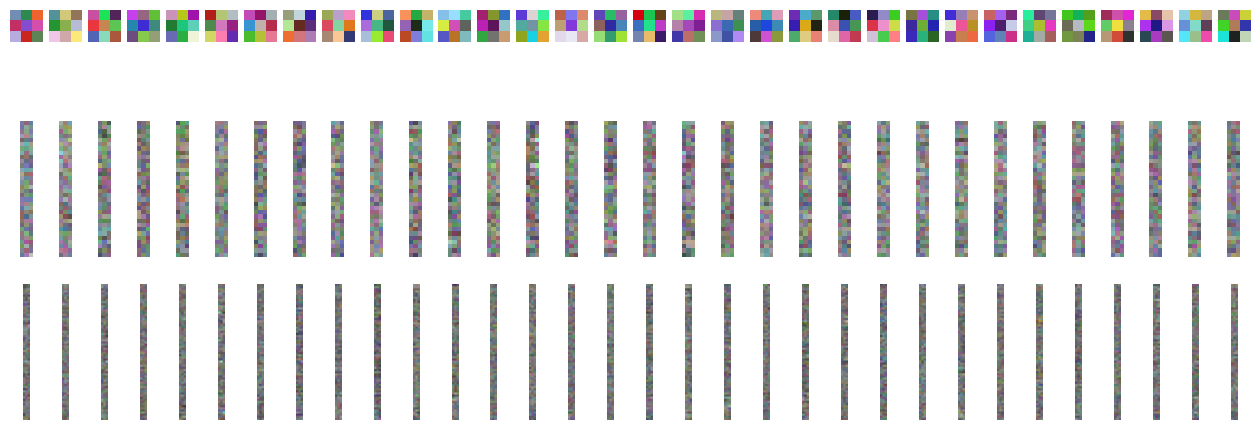

In [4]:
import matplotlib.pyplot as plt

# Access the filter weights
conv1_weights = model.conv1.weight
conv2_weights = model.conv2.weight
conv3_weights = model.conv3.weight

# Normalize the filter weights
conv1_weights_normalized = (conv1_weights - conv1_weights.min()) / (conv1_weights.max() - conv1_weights.min())
conv2_weights_normalized = (conv2_weights - conv2_weights.min()) / (conv2_weights.max() - conv2_weights.min())
conv3_weights_normalized = (conv3_weights - conv3_weights.min()) / (conv3_weights.max() - conv3_weights.min())

# Plot the filters
fig, axs = plt.subplots(3, 32, figsize=(16, 6))
for i in range(32):
    axs[0, i].imshow(conv1_weights_normalized[i].detach().cpu().squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(conv2_weights_normalized[i].detach().cpu().squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(conv3_weights_normalized[i].detach().cpu().squeeze(), cmap='gray')
    axs[2, i].axis('off')

plt.show()


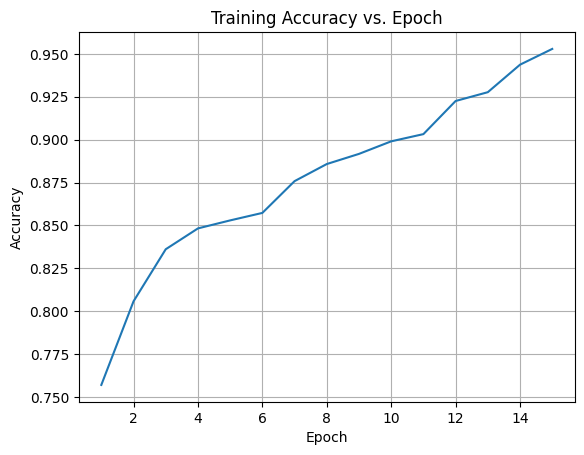

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epoch')
plt.grid(True)
plt.show()

In [9]:
# Assuming similar data transformations for validation set
val_dataset = ImageFolder('val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle for validation
val_accuracies = []
# Load the trained model
model = FirstModel()
model.load_state_dict(torch.load('normModel.pth'))
model.eval()  # Set the model to evaluation mode

# Evaluation loop
val_accuracies = []

# Evaluation loop for 15 epochs

val_correct_predictions = 0
val_total_samples = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_samples += labels.size(0)
    
val_accuracy = val_correct_predictions / val_total_samples
val_accuracies.append(val_accuracy)
print(f"Epoch {epoch+1} - Validation Accuracy: {val_accuracy:.4f}")

# Print the accuracy values
for epoch, accuracy in enumerate(val_accuracies):
    print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy:.4f}")

# Validation Accuracy: 0.8371 ----
# Validation Accuracy: 0.8067 ++++
# Validation Accuracy: 0.8570 +---
# Validation Accuracy: 0.8307 -+--
# Validation Accuracy: 0.8155 ++--
# Validation Accuracy: 0.8403 --+-
# Validation Accuracy: 0.8131 ---+

Epoch 10 - Validation Accuracy: 0.7556
Epoch 1 - Validation Accuracy: 0.7556


Blind Test

In [10]:
# Load the model from the file
model = FirstModel().to(device)
model.load_state_dict(torch.load('normModel.pth'))

# Load the images from test_blind
test_dataset = ImageFolder('test_blind', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create a dictionary to map the class indices to the labels
class_dict = {0: 'MEL', 1: 'NV'}

# Create a list to store the predictions
predictions = []

# Predict the classes for the images
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend([class_dict[p.item()] for p in predicted])

# Save the predictions to a file
with open('predictions.txt', 'w') as f:
    for p in predictions:
        f.write(p + '\n')


In [11]:
with open('predictions.txt') as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])

Test Accuracy: 0.4876


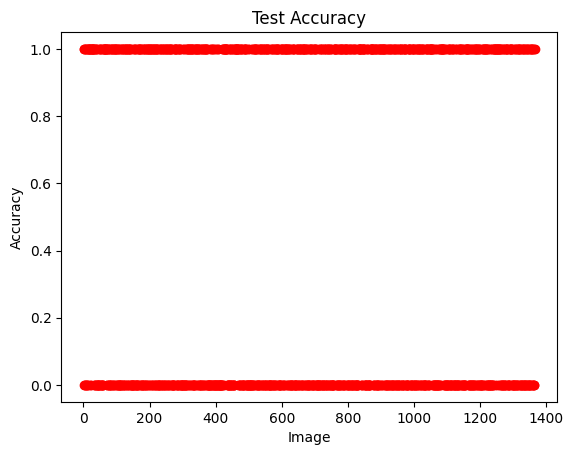

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Load the model from the file
model = FirstModel().to(device)
model.load_state_dict(torch.load('normModel.pth'))

# Load the images from test_blind
test_dataset = ImageFolder('test_blind', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create a dictionary to map the class indices to the labels
class_dict = {0: 'MEL', 1: 'NV'}

# Create lists to store the ground truth labels and predicted labels
ground_truth_labels = []
predicted_labels = []

# Predict the classes for the images
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend([class_dict[p.item()] for p in predicted])
        ground_truth_labels.extend([class_dict[l.item()] for l in labels])

# Calculate the test accuracy
test_correct_predictions = sum([1 for p, gt in zip(predicted_labels, ground_truth_labels) if p == gt])
test_total_samples = len(ground_truth_labels)
test_accuracy = test_correct_predictions / test_total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot the test accuracy
epochs = np.arange(len(predicted_labels)) + 1
plt.plot(epochs, [int(p == gt) for p, gt in zip(predicted_labels, ground_truth_labels)], 'ro')
plt.xlabel('Image')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()
